In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.optimize import curve_fit
from scipy.integrate import quad
import multiprocessing as mp
import gc
from astropy.io import fits

In [2]:
plt.rc('font',size=25)
pd.set_option('max_column',200)

In [35]:
x=fits.open('../Downloads/fpC-200006-r1-0248.fit')
y=fits.open('../Downloads/fpC-200006-r1-0249.fit')
z=fits.open('../Downloads/fpC-200006-r1-0349.fit')

In [81]:
y[0].header

SIMPLE  =                    T                                                  
BITPIX  =                  -32                                                  
NAXIS   =                    2                                                  
NAXIS1  =                 2048                                                  
NAXIS2  =                 1489                                                  
RADECSYS= 'ICRS    '                                                            
CTYPE1  = 'DEC--TAN'                                                            
CTYPE2  = 'RA---TAN'                                                            
CUNIT1  = 'deg     '                                                            
CUNIT2  = 'deg     '                                                            
CRPIX1  = 1.02500000000000E+03                                                  
CRPIX2  = 7.45000000000000E+02                                                  
CRVAL1  = -9.4398000000000E-

In [42]:
x[0].header[18]

'fpCs-001033-r1-0133.resamp.fits'

In [68]:
fs

,fieldID,skyVersion,run,rerun,camcol,field,nObjects,nChild,nGalaxy,nStars,raMin,raMax,decMin,decMax,mjd_u,mjd_g,mjd_r,mjd_i,mjd_z
0,8647474690312306688,15,106,2,1,63,4075,2291,929,2162,309.275240,309.438715,-1.266345,-1.041694,0.000000,0.000000,0.000000,0.000000,0.000000
1,8647474690312372224,15,106,2,1,64,2897,1483,674,1531,309.425185,309.588205,-1.266345,-1.042056,0.000000,0.000000,0.000000,0.000000,0.000000
2,8647474690312437760,15,106,2,1,65,2639,1321,645,1388,309.574893,309.738140,-1.266343,-1.041957,0.000000,0.000000,0.000000,0.000000,0.000000
3,8647474690312503296,15,106,2,1,66,3947,2202,973,2018,309.724250,309.887840,-1.266345,-1.041828,0.000000,0.000000,0.000000,0.000000,0.000000
4,8647474690312568832,15,106,2,1,67,3751,2073,868,1972,309.873864,310.037550,-1.266345,-1.041942,0.000000,0.000000,0.000000,0.000000,0.000000
5,8647474690312634368,15,106,2,1,68,3681,1933,780,1964,310.023575,310.187255,-1.266346,-1.041611,0.000000,0.000000,0.000000,0.000000,0.000000
6,8647474690312699904,15,106,2,1,69,3989,2205,1030,1987,310.173294,310.336980,-1.266345,-1.041527,0.000000,0.000000,0.000000,0.000000,0.000000
7,8647474690312765440,15,106,2,1,70,4008,2251,977,2042,310.323003,310.486690,-1.266244,-1.041503,0.000000,0.000000,0.000000,0.000000,0.000000
8,8647474690312830976,15,106,2,1,71,3879,2128,1006,1917,310.473153,310.636173,-1.266344,-1.041789,0.000000,0.000000,0.000000,0.000000,0.000000
9,8647474690312896512,15,106,2,1,72,4021,2281,991,2028,310.622412,310.786093,-1.265905,-1.041504,0.000000,0.000000,0.000000,0.000000,0.000000


In [77]:
def epoch(i):
    a=int(np.ceil(i/6))
    b=i-6*a+6
    pwd='/home/tian.qiu/data/catalog/S82-fits/imaging/'+str(a)+'00006/2/corr/'+str(b)+'-c/'
    tt=[]
    for j in range(62,801):
        x=fits.open(pwd+'fpC-'+str(a)+'00006-r'+str(b)+'-'+str(j).zfill(4)+'.fit')
        t={'coadd-run': a*100+6, 'coadd-camcol': b, 'coadd-field': j}
        for k in range(len(x[0].header[18:])):
            run=int(x[0].header[k+18][7:11])
            camcol=int(x[0].header[k+18][13])
            field=int(x[0].header[k+18][15:19])
            t.update({'c'+'run'+str(k):run,'c'+'camcol'+str(k):camcol,'c'+'field'+str(k):field})
        tt.append(pd.Series(t))
    ttt=pd.DataFrame(tt)
    return ttt

In [3]:
se=pd.read_csv('../Downloads/catalog/final/S82_mjd.csv')

In [10]:
se[pd.isna(se.mjd_r2)]

,Unnamed: 0,camcol,field,run,mjd_r0,mjd_r1,mjd_r10,mjd_r11,mjd_r12,mjd_r13,...,mjd_r7,mjd_r70,mjd_r71,mjd_r72,mjd_r73,mjd_r74,mjd_r75,mjd_r8,mjd_r9,S82_mean_mjd
833,833,2.0,156.0,106.0,52576.128531,52576.128946,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52576.128739
834,834,2.0,157.0,106.0,53705.109194,53705.109608,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53705.109401


In [19]:
se.iloc[611]

Unnamed: 0        611.000000
camcol              1.000000
field             673.000000
run               106.000000
mjd_r0          51081.394588
mjd_r1          51081.395002
mjd_r10         52522.426798
mjd_r11         52522.427213
mjd_r12         52551.398091
mjd_r13         52551.398506
mjd_r14         52558.431006
mjd_r15         52558.431420
mjd_r16         52578.302619
mjd_r17         52578.303034
mjd_r18         52585.265235
mjd_r19         52585.265649
mjd_r2          51819.465416
mjd_r20         52585.266064
mjd_r21         52909.432103
mjd_r22         52909.432517
mjd_r23         52910.402222
mjd_r24         52910.402636
mjd_r25         52935.329464
mjd_r26         52935.329878
mjd_r27         52963.252670
mjd_r28         52963.253084
mjd_r29         52971.243269
mjd_r3          51819.465831
mjd_r30         52971.243683
mjd_r31         53351.174790
                    ...     
mjd_r51         53676.417435
mjd_r52         53679.388850
mjd_r53         53679.389264
mjd_r54       

In [4]:
se=se.drop('Unnamed: 0',axis=1)

In [5]:
def ran(i):
    n=0
    t=se.iloc[i]
    tt={'run': t['run'], 'camcol': t['camcol'], 'field': t['field']}
    ma=t['mjd_r'+str(0)]
    mi=t['mjd_r'+str(0)]
    for j in range(76):
        if pd.notna(t['mjd_r'+str(j)]):
            n=n+1
            if ma<t['mjd_r'+str(j)]:
                ma=t['mjd_r'+str(j)]
            if mi>t['mjd_r'+str(j)]:
                mi=t['mjd_r'+str(j)]  
    tt.update({'num':n})
    tt.update({'max':ma})
    tt.update({'min':mi})
    tt.update({'range':ma-mi})
    print(n)
    return tt

In [8]:
pool1=mp.Pool(20)
data=pool1.map(ran,range(len(se)))
pool1.close()

8
41
49
41
45
41
51
43
61
41
48
63
49
52
34
40
46
41
34
43
52
47
37
56
59
49
45
62
41
51
43
46
50
32
51
39
28
48
42
42
52
39
47
56
59
47
43
41
62
49
43
49
34
28
52
41
47
46
44
40
54
37
51
58
61
47
41
41
62
49
49
47
32
34
57
41
47
48
44
44
57
37
52
61
47
64
41
41
64
49
47
47
32
32
55
41
45
46
44
45
57
39
63
50
51
66
45
41
64
49
47
51
30
38
53
41
47
46
44
47
37
57
63
50
49
68
43
43
60
49
47
50
30
34
49
40
47
46
47
44
37
63
48
55
49
43
64
43
60
49
50
49
32
34
51
38
47
48
44
49
37
48
63
54
51
45
41
64
60
51
52
30
52
34
38
51
45
48
40
49
37
48
63
54
51
43
39
62
60
51
53
30
52
36
38
45
53
38
48
49
37
50
63
54
51
43
41
63
61
51
50
32
52
38
38
49
38
55
50
49
37
50
54
63
51
43
39
61
49
61
49
34
39
52
40
50
40
54
50
47
37
50
56
62
51
43
37
60
47
49
59
34
35
52
43
52
40
35
41
33
34
36
36
47
36
36
48
56
49
34
36
50
52
37
47
49
46
52
36
35
40
36
37
38
37
51
56
47
51
37
35
49
37
37
48
51
46
52
39
41
47
38
37
45
38
37
38
37
40
40
35
37
46
56
41
51
47
54
35
40
49
47
40
40
39
49
49
37
41
51
47
40
39
40

In [9]:
data[0]

In [11]:
x

In [14]:
ran1=pd.DataFrame(data)

In [ ]:
ran1

In [3]:
fs=pd.read_csv('../Downloads/catalog/field_Tian_Qiu.csv')

In [16]:
fs.mjd_r-fs.mjd_i

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
5         0.000000
6         0.000000
7         0.000000
8         0.000000
9         0.000000
10        0.000000
11        0.000000
12        0.000000
13        0.000000
14        0.000000
15        0.000000
16        0.000000
17        0.000000
18        0.000000
19        0.000000
20        0.000000
21        0.000000
22        0.000000
23        0.000000
24        0.000000
25        0.000000
26        0.000000
27        0.000000
28        0.000000
29        0.000000
            ...   
746889   -0.000829
746890   -0.000829
746891   -0.000829
746892   -0.000829
746893   -0.000829
746894   -0.000829
746895   -0.000829
746896   -0.000829
746897   -0.000829
746898   -0.000829
746899   -0.000829
746900   -0.000829
746901   -0.000829
746902   -0.000829
746903   -0.000829
746904   -0.000829
746905   -0.000829
746906   -0.000829
746907   -0.000829
746908   -0.000829
746909   -0.000829
746910   -0.

(array([     0., 738043.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   8868.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.]),
 array([-1.00000000e-03, -9.00000000e-04, -8.00000000e-04, -7.00000000e-04,
        -6.00000000e-04, -5.00000000e-04, -4.00000000e-04, -3.00000000e-04,
        -2.00000000e-04, -1.00000000e-04,  4.33680869e-19,  1.00000000e-04,
         2.00000000e-04,  3.00000000e-04,  4.00000000e-04,  5.00000000e-04,
         6.00000000e-04,  7.00000000e-04,  8.00000000e-04,  9.00000000e-04]),
 <a list of 19 Patch objects>)

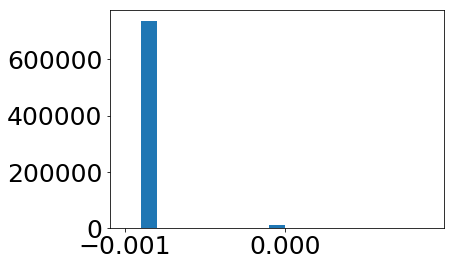

In [17]:
plt.hist(fs.mjd_r-fs.mjd_i,bins=np.arange(-0.001,0.001,0.0001))

In [116]:
se[se.crun32==5847]

,Unnamed: 0,ccamcol0,ccamcol1,ccamcol10,ccamcol11,ccamcol12,ccamcol13,ccamcol14,ccamcol15,ccamcol16,ccamcol17,ccamcol18,ccamcol19,ccamcol2,ccamcol20,ccamcol21,ccamcol22,ccamcol23,ccamcol24,ccamcol25,ccamcol26,ccamcol27,ccamcol28,ccamcol29,ccamcol3,ccamcol30,ccamcol31,ccamcol32,ccamcol33,ccamcol34,ccamcol35,ccamcol36,ccamcol37,ccamcol38,ccamcol39,ccamcol4,ccamcol40,ccamcol41,ccamcol42,ccamcol43,ccamcol44,ccamcol45,ccamcol46,ccamcol47,ccamcol48,ccamcol49,ccamcol5,ccamcol50,ccamcol51,ccamcol52,ccamcol53,ccamcol54,ccamcol55,ccamcol56,ccamcol57,ccamcol58,ccamcol59,ccamcol6,ccamcol60,ccamcol61,ccamcol62,ccamcol63,ccamcol64,ccamcol65,ccamcol66,ccamcol67,ccamcol68,ccamcol69,ccamcol7,ccamcol70,ccamcol71,ccamcol72,ccamcol73,ccamcol74,ccamcol75,ccamcol8,ccamcol9,cfield0,cfield1,cfield10,cfield11,cfield12,cfield13,cfield14,cfield15,cfield16,cfield17,cfield18,cfield19,cfield2,cfield20,cfield21,cfield22,cfield23,cfield24,cfield25,cfield26,cfield27,cfield28,cfield29,...,cfield59,cfield6,cfield60,cfield61,cfield62,cfield63,cfield64,cfield65,cfield66,cfield67,cfield68,cfield69,cfield7,cfield70,cfield71,cfield72,cfield73,cfield74,cfield75,cfield8,cfield9,coadd-camcol,coadd-field,coadd-run,crun0,crun1,crun10,crun11,crun12,crun13,crun14,crun15,crun16,crun17,crun18,crun19,crun2,crun20,crun21,crun22,crun23,crun24,crun25,crun26,crun27,crun28,crun29,crun3,crun30,crun31,crun32,crun33,crun34,crun35,crun36,crun37,crun38,crun39,crun4,crun40,crun41,crun42,crun43,crun44,crun45,crun46,crun47,crun48,crun49,crun5,crun50,crun51,crun52,crun53,crun54,crun55,crun56,crun57,crun58,crun59,crun6,crun60,crun61,crun62,crun63,crun64,crun65,crun66,crun67,crun68,crun69,crun7,crun70,crun71,crun72,crun73,crun74,crun75,crun8,crun9
2215,737,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,472.0,473.0,197.0,198.0,271.0,272.0,273.0,507.0,508.0,802.0,803.0,278.0,306.0,279.0,828.0,829.0,840.0,841.0,93.0,94.0,646.0,647.0,705.0,...,NaN,272.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,273.0,NaN,NaN,NaN,NaN,NaN,NaN,717.0,718.0,3.0,799.0,106.0,125.0,125.0,3438.0,3438.0,3460.0,3460.0,3460.0,4145.0,4145.0,4203.0,4203.0,5042.0,2886.0,5042.0,5607.0,5607.0,5646.0,5646.0,5732.0,5732.0,5786.0,5786.0,5820.0,2886.0,5820.0,5847.0,5847.0,5889.0,5889.0,5895.0,5895.0,5905.0,5905.0,NaN,3325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3355.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3355.0,NaN,NaN,NaN,NaN,NaN,NaN,3388.0,3388.0


In [45]:
fs.loc[a].mjd_r.values.shape[0]

1

## figure out single exposure epoch for each field in run 106/206

In [53]:
def mjds82(i):#for i in range(len(se)):
    print(i)
    t=se.iloc[i]
    tt={'coadd_run': t['coadd-run'], 'coadd_camcol': t['coadd-camcol'], 'coadd_field': t['coadd-field']}
    for k in range(76):
        if pd.isna(t['crun'+str(k)]):
            continue
        run=t['crun'+str(k)]
        camcol=t['ccamcol'+str(k)]
        field=t['cfield'+str(k)]
        if run==5847:
            mjd=53684
        else:
            mjd=fs[(fs.run==run)&(fs.camcol==camcol)&(fs.field==field)].mjd_r.values[0]
        tt.update({'mjd_r'+str(k):mjd})
    return tt


In [54]:
pool1=mp.Pool(20)
data=pool1.map(mjds82,range(len(se)))
pool1.close()

222
111
0
333
444
555
666
777
888
999
1221
1665
1776
1554
1887
1998
2109
1110
1332
1443
1
1555
112
223
1666
778
2
1222
1111
889
1888
1777
334
445
1333
1999
1000
1444
2110
556
667
1556
3
224
113
1667
779
1112
1223
1889
890
1778
446
335
4
1334
1557
1001
2000
1445
2111
225
114
557
780
668
1668
1113
1890
5
1558
891
1224
1779
336
447
1002
1446
1335
226
2001
115
6
1559
781
1669
1891
2112
1114
892
558
1225
1780
669
337
227
7
448
1447
1003
116
1560
782
2002
1336
1670
893
1892
1115
8
1226
228
2113
1781
1561
338
559
117
1448
783
1004
449
670
9
1671
2003
1893
894
1337
229
1116
1562
1782
1227
118
10
339
784
1449
2114
1005
450
560
1672
895
1563
230
1894
11
2004
671
1117
1338
119
1783
1228
785
340
1450
1564
231
1006
12
1673
896
451
2115
1895
120
1118
1339
2005
1784
561
786
1565
1229
672
13
232
1451
341
1674
897
1007
121
452
1896
787
14
1119
1566
1785
1340
233
2006
2116
1675
1452
1230
898
122
342
562
673
1008
453
15
1567
788
1897
234
1676
1786
1120
1341
2007
123
1453
899
1568
16
1231
2117
343
454
789

1202
1869
207
627
1767
2224
884
2075
2182
2333
1406
419
1663
752
988
1087
310
1203
1870
2225
208
527
1979
1302
1768
885
753
2076
628
2334
1664
2183
989
1088
420
2226
1407
1204
1871
311
209
754
528
886
1769
1980
2335
2077
2442
1303
2227
2184
629
1089
990
755
421
210
1205
1872
312
887
2336
1408
2228
2443
529
1770
1981
2078
756
2185
991
211
1090
1873
1304
1206
630
422
2229
2337
2553
313
2444
757
1771
1982
530
1409
2079
2230
212
2186
992
1874
2338
1091
1207
2445
758
423
2554
1305
314
631
1772
2231
1983
213
2339
531
2187
2080
1875
1208
993
1410
1092
759
2446
2232
2555
424
1773
315
1306
2340
214
1984
632
1209
760
1876
2188
2447
532
2233
1093
994
2081
1411
2341
2556
425
215
1774
1210
316
761
1985
2234
2448
1307
1877
2189
633
1094
995
533
2082
2342
216
1211
762
1412
2235
1775
2557
426
2449
317
1986
1095
1878
2190
1308
996
1212
763
634
217
2236
2343
534
2083
2450
2664
2558
1413
427
318
1096
1987
764
1213
1879
2191
2237
218
2344
1309
997
2451
2084
535
2665
635
428
2559
765
1097
2238
1214
319
219

3389
3730
4355
2834
2630
3182
3081
2424
3495
2330
2522
3837
3599
3943
4254
4156
3280
4044
3731
3390
2947
2738
3183
2631
3082
2425
4440
2835
4356
3838
3496
4157
2523
3944
3281
3732
3184
3391
4045
2948
3600
4441
4255
3083
2739
2632
2426
3839
4158
3185
3733
2836
4357
3282
3945
4442
3497
2524
3392
4046
2949
3084
2427
2633
2740
3840
3601
3186
4256
4159
3734
4443
3283
3946
3085
2837
3393
2950
2525
4047
4358
3498
2428
3841
3187
4444
2634
3735
4160
2741
3086
3284
3947
4257
2951
3602
3394
2429
4048
3188
4445
3842
2526
2838
3499
3736
4161
4359
2635
3087
3285
3948
3189
2952
2430
4446
4258
2742
3843
3395
4049
3737
4162
2527
3603
2839
3500
3088
2636
3190
4447
3286
3949
4360
2953
2431
3844
4163
3738
4050
3396
2743
4259
4448
2528
3191
3089
2840
2637
4164
2954
2432
3501
3287
3950
3604
3845
3739
4051
4361
3397
4449
3192
3090
2744
4165
2529
2955
4260
2433
2638
2841
3846
3951
3288
3740
2956
4052
3502
4450
2957
3193
3605
3091
4166
3398
4362
2745
2434
2530
3741
3847
2639
3289
3952
2958
4261
4053
4451
2842


5147
5270
6233
5475
5795
4623
6019
4433
6438
5373
5907
4821
4718
4434
6127
4544
5033
5271
4925
6020
4435
4624
5687
6331
5581
5148
6234
5908
5476
5374
4719
5796
4822
6128
6439
4436
4545
6021
5272
4625
5909
6332
5375
5582
5149
4926
6235
5034
5477
6129
5688
4437
4720
4823
4546
5797
6022
5273
4626
6440
5910
4438
5376
6130
6333
5583
6236
5150
5478
4547
4721
6023
4824
5035
4927
5689
4627
5274
4439
5798
5911
5377
6131
6441
6334
6024
5912
6237
4548
5479
5584
5151
6549
4722
5275
4628
4825
5378
5913
6132
5036
4928
5690
5799
6025
4549
6335
5480
5276
4629
6238
5152
5914
6442
5585
4723
5379
6133
6550
4826
6026
4550
5037
5915
4929
5277
5800
4630
5481
5691
6336
6134
5380
6239
5153
4724
5586
5916
6027
4827
6443
6551
6660
5278
4631
6135
5482
5381
5038
6337
5801
5917
4930
5154
6240
6661
5692
4725
6028
5587
4828
5279
6552
4632
5918
5382
6136
6444
6662
5483
6338
6029
5802
6241
5039
5155
4726
5588
4931
5280
5919
4633
5383
6663
6137
5693
4829
6553
5484
6030
6445
5920
6339
6664
6242
5156
5281
4727
5384
5589


5865
7233
6756
7128
7021
7665
7458
5752
6504
6312
5102
6211
7559
6828
6404
6916
6617
4989
6757
7343
5657
7459
5866
7022
7129
7666
7234
7560
6829
6313
5753
6212
6505
5103
6758
6917
6618
7460
6405
4990
7344
7561
5658
5867
7023
6830
7667
7130
6314
6759
7461
6213
7235
6918
5754
6506
6619
5104
7562
6406
6831
4991
7462
6760
5868
7024
5659
7668
7345
6315
6214
7131
6620
6919
7563
7236
5105
6832
6507
7463
5755
6761
6407
4992
7025
5869
7669
7346
5660
6316
7564
6215
6621
7464
6833
7132
6920
6762
7770
7237
6508
5756
7670
7026
6408
5870
4993
7565
7465
6834
6763
7881
6317
7347
6622
7992
6921
7133
7771
7466
7566
7671
7238
6509
6764
5871
7027
6835
5757
6409
4994
6623
6318
7348
7882
6922
7467
7993
7567
7134
7672
6765
7772
6836
7239
5872
7028
6624
6510
6410
6319
8103
5758
7468
7349
7568
7883
6923
6766
7673
6837
7994
7135
7773
5873
7029
7469
6625
7569
6320
7240
6411
8104
6767
6511
5759
7350
6838
7674
6924
7884
7774
7470
7570
7995
7136
5874
7030
6626
6768
6321
8105
7241
6839
6412
7351
7675
6512
5760
6925


7753
7304
8807
8060
8699
8208
8608
7947
8509
7658
8305
7849
7199
8406
7754
8209
8808
7305
8061
8700
8306
8609
8407
8510
7850
7948
7755
8210
7200
8809
8307
8062
7306
8701
8408
8511
8610
7756
7851
8211
7949
8308
8810
7201
8409
8063
7307
8212
7757
8702
8512
7852
8611
8309
7950
8811
8410
8213
7758
8064
7202
7308
8513
8310
8703
7853
8612
7951
8411
8812
7759
8065
8311
8514
7203
7309
8704
7854
8613
8412
7952
8813
7760
8312
8066
8515
7204
7310
8705
7855
8413
8614
8313
7761
8814
7953
8516
8067
7856
8706
8414
7311
7205
8314
8615
7762
8815
7954
8517
8068
8415
8315
7857
8707
7312
7206
7763
8816
8616
8518
7955
8316
8416
8069
7858
8708
7764
8817
7313
8519
7207
8617
8317
7956
8417
8070
7859
8709
7765
8818
8318
8520
7314
7208
8418
8618
7957
8071
7860
8319
7766
8710
8819
8521
8419
7315
8619
7209
7958
8320
8072
7861
7767
8522
8820
8420
8711
7316
8321
8620
7210
8073
7959
7862
8421
8523
7768
8322
8712
8821
7317
8621
7211
8074
7960
8422
8323
7863
8524
7769
8713
8822
8622
8324
7318
8423
7212
8075
8525
7864


In [56]:
smjd=pd.DataFrame(data)

In [65]:
smjd['S82_mean_mjd']=smjd.iloc[:,3:].mean(1)

In [92]:
smjd.rename(columns={'coadd-camcol': 'camcol'}, inplace=True)
smjd.rename(columns={'coadd-run': 'run'}, inplace=True)
smjd.rename(columns={'coadd-field': 'field'}, inplace=True)

In [93]:
smjd.to_csv('../Downloads/catalog/S82_mjd.csv')

In [69]:
m=pd.read_csv('../Downloads/catalog/m_both_all_i<24.2_ira_c_err_epoch.csv')
    

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,11,12,14,16,19,20,22,70,71,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [71]:
m.rename(columns={'mean_mjd': 'HSC_mean_mjd'}, inplace=True)

In [95]:
smjd2=smjd.iloc[:,[0,1,2,-1]]

In [103]:
smjd2[smjd2.field==396]

,camcol,field,run,S82_mean_mjd
334,1.0,396.0,106.0,53185.041740
1073,2.0,396.0,106.0,53142.842165
1812,3.0,396.0,106.0,53131.086150
2551,4.0,396.0,106.0,53163.925827
3290,5.0,396.0,106.0,53163.925827
4029,6.0,396.0,106.0,53191.108858
4768,1.0,396.0,206.0,53125.861647
5507,2.0,396.0,206.0,53142.773457
6246,3.0,396.0,206.0,53135.057416
6985,4.0,396.0,206.0,53142.773457


In [101]:
m=m.merge(smjd2, how='left', on=['run','camcol','field'])

In [104]:
m.to_csv('../Downloads/catalog/m_both_all_i<24.2_ira_c_err_epoch.csv')

## S82 epoch for stars after calibration

In [3]:
smjd=pd.read_csv('../Downloads/catalog/S82_mjd.csv')

In [4]:
smjd2=smjd.iloc[:,[1,2,3,-1]]

In [7]:
s=pd.read_csv('../Downloads/catalog/final/S82all.csv')

In [9]:
s=s.merge(smjd2, how='left', on=['run','camcol','field'])

In [12]:
s['ra'][s.ra>180]=s[s.ra>180].ra-360

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [15]:
s.to_csv('../Downloads/catalog/final/S82all.csv',index=False)

In [5]:
ms=pd.read_csv('../Downloads/catalog/star_after_calibration.csv')

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
ms=ms.merge(smjd2, how='left', on=['run','camcol','field'])

In [12]:
ms['delta_mjd']=ms.HSC_mean_mjd-ms.S82_mean_mjd
ms['delta_yr']=ms.delta_mjd/365.24
ms['pmra_cl']=ms.dra_cl/ms.delta_yr
ms['pmdec_cl']=ms.ddec_cl/ms.delta_yr

In [15]:
ms['pmra_cl_err']=ms.dra_err/ms.delta_yr
ms['pmdec_cl_err']=ms.ddec_err/ms.delta_yr

In [16]:
ms.to_csv('../Downloads/catalog/star_after_calibration.csv')

In [29]:
cc=['col1','coadd-run','coadd-camcol','coadd-field','num']
for i in range(76):
    cc.append('crun'+str(i))
    cc.append('ccamcol'+str(i))
    cc.append('cfield'+str(i))

In [42]:
se=se[cc]

In [44]:
for i in range(len(se)):
    t=se.iloc[i]
    n=0
    for j in range(76):
        if pd.notna(t['crun'+str(j)]):
            n=n+1
        else:
            break
    se['num'].iloc[i]=n

/Users/tianqiu/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
se.to_csv('../Downloads/catalog/S82coaddepoch.csv')

In [47]:
se

,col1,coadd-run,coadd-camcol,coadd-field,num,crun0,ccamcol0,cfield0,crun1,ccamcol1,cfield1,crun2,ccamcol2,cfield2,crun3,ccamcol3,cfield3,crun4,ccamcol4,cfield4,crun5,ccamcol5,cfield5,crun6,ccamcol6,cfield6,crun7,ccamcol7,cfield7,crun8,ccamcol8,cfield8,crun9,ccamcol9,cfield9,crun10,ccamcol10,cfield10,crun11,ccamcol11,cfield11,crun12,ccamcol12,cfield12,crun13,ccamcol13,cfield13,crun14,ccamcol14,cfield14,crun15,ccamcol15,cfield15,crun16,ccamcol16,cfield16,crun17,ccamcol17,cfield17,crun18,ccamcol18,cfield18,crun19,ccamcol19,cfield19,crun20,ccamcol20,cfield20,crun21,ccamcol21,cfield21,crun22,ccamcol22,cfield22,crun23,ccamcol23,cfield23,crun24,ccamcol24,cfield24,crun25,ccamcol25,cfield25,crun26,ccamcol26,cfield26,crun27,ccamcol27,cfield27,crun28,ccamcol28,cfield28,crun29,ccamcol29,cfield29,crun30,ccamcol30,cfield30,crun31,ccamcol31,...,cfield42,crun43,ccamcol43,cfield43,crun44,ccamcol44,cfield44,crun45,ccamcol45,cfield45,crun46,ccamcol46,cfield46,crun47,ccamcol47,cfield47,crun48,ccamcol48,cfield48,crun49,ccamcol49,cfield49,crun50,ccamcol50,cfield50,crun51,ccamcol51,cfield51,crun52,ccamcol52,cfield52,crun53,ccamcol53,cfield53,crun54,ccamcol54,cfield54,crun55,ccamcol55,cfield55,crun56,ccamcol56,cfield56,crun57,ccamcol57,cfield57,crun58,ccamcol58,cfield58,crun59,ccamcol59,cfield59,crun60,ccamcol60,cfield60,crun61,ccamcol61,cfield61,crun62,ccamcol62,cfield62,crun63,ccamcol63,cfield63,crun64,ccamcol64,cfield64,crun65,ccamcol65,cfield65,crun66,ccamcol66,cfield66,crun67,ccamcol67,cfield67,crun68,ccamcol68,cfield68,crun69,ccamcol69,cfield69,crun70,ccamcol70,cfield70,crun71,ccamcol71,cfield71,crun72,ccamcol72,cfield72,crun73,ccamcol73,cfield73,crun74,ccamcol74,cfield74,crun75,ccamcol75,cfield75
0,0,106.0,1.0,62.0,8,4930.0,1.0,52.0,4930.0,1.0,53.0,5754.0,1.0,50.0,5754.0,1.0,51.0,5797.0,1.0,59.0,5797.0,1.0,60.0,5924.0,1.0,87.0,5924.0,1.0,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,106.0,1.0,63.0,34,2583.0,1.0,42.0,2583.0,1.0,43.0,3360.0,1.0,22.0,3360.0,1.0,23.0,4187.0,1.0,11.0,4187.0,1.0,12.0,4192.0,1.0,17.0,4192.0,1.0,18.0,4203.0,1.0,66.0,4203.0,1.0,67.0,4930.0,1.0,53.0,4930.0,1.0,54.0,5597.0,1.0,97.0,5597.0,1.0,98.0,5619.0,1.0,96.0,5619.0,1.0,97.0,5628.0,1.0,97.0,5628.0,1.0,98.0,5675.0,1.0,70.0,5675.0,1.0,71.0,5754.0,1.0,51.0,5754.0,1.0,52.0,5763.0,1.0,61.0,5763.0,1.0,62.0,5776.0,1.0,66.0,5776.0,1.0,67.0,5797.0,1.0,59.0,5797.0,1.0,60.0,5797.0,1.0,61.0,5905.0,1.0,120.0,5905.0,1.0,121.0,5924.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,106.0,1.0,64.0,28,3360.0,1.0,23.0,3360.0,1.0,24.0,4187.0,1.0,12.0,4187.0,1.0,13.0,4192.0,1.0,18.0,4192.0,1.0,19.0,4203.0,1.0,67.0,4203.0,1.0,68.0,4930.0,1.0,54.0,4930.0,1.0,55.0,5628.0,1.0,98.0,5628.0,1.0,99.0,5675.0,1.0,71.0,5675.0,1.0,72.0,5754.0,1.0,52.0,5754.0,1.0,53.0,5763.0,1.0,62.0,5763.0,1.0,63.0,5776.0,1.0,67.0,5776.0,1.0,68.0,5797.0,1.0,60.0,5797.0,1.0,61.0,5797.0,1.0,62.0,5905.0,1.0,121.0,5905.0,1.0,122.0,5924.0,1.0,88.0,5924.0,1.0,89.0,5924.0,1.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...